# Import Libraries

In [1]:
!pip install Sastrawi

In [104]:
import os
import re
import time
import json
import unicodedata
import string
import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import List, Tuple, defaultdict
from collections import Counter
import joblib
import zipfile
import os
from google.colab import files

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data Undertanding

In [3]:
# path dataset
path = "/content/review_medsos_all.csv"

# read dataset
df = pd.read_csv(path)
df.head()

,review,rating,tanggal
0,CiNTHyA,5,2025-10-27 05:16:48
1,Sangat bagus,5,2025-10-26 17:33:41
2,Jelek banget aplikasinya gak bisa buat live,5,2025-10-26 15:20:20
3,Keren,5,2025-10-26 03:48:45
4,good,4,2025-10-26 00:30:13


In [4]:
# hapus baris 1 karena tidak jelas
df.drop(0, inplace=True)
df.head()

,review,rating,tanggal
1,Sangat bagus,5,2025-10-26 17:33:41
2,Jelek banget aplikasinya gak bisa buat live,5,2025-10-26 15:20:20
3,Keren,5,2025-10-26 03:48:45
4,good,4,2025-10-26 00:30:13
5,sangat bagus,5,2025-10-24 22:15:17


In [5]:
# shape data
df.shape

(4976, 3)

In [6]:
# info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4976 entries, 1 to 4976
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   4976 non-null   object
 1   rating   4976 non-null   int64 
 2   tanggal  4976 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.8+ KB


In [7]:
# ambil fitur reviews dan rating
df = df.iloc[:, :2]
df.head()

,review,rating
1,Sangat bagus,5
2,Jelek banget aplikasinya gak bisa buat live,5
3,Keren,5
4,good,4
5,sangat bagus,5


# Data Labeling

In [8]:
# function label
def labelling(rating):
  if rating >= 4:
    return 'positif'
  elif rating <= 2:
    return 'negatif'

df['sentiment'] = df['rating'].apply(labelling)
df.head()

,review,rating,sentiment
1,Sangat bagus,5,positif
2,Jelek banget aplikasinya gak bisa buat live,5,positif
3,Keren,5,positif
4,good,4,positif
5,sangat bagus,5,positif


In [9]:
# distribusi sentiment
df['sentiment'].value_counts()

,count
sentiment,
positif,2992
negatif,1681


# Data Preprocessing

In [10]:
# cek nilai null
df.isnull().sum()

,0
review,0
rating,0
sentiment,303


In [11]:
# drop nilai null
df.dropna(inplace=True)
df.isnull().sum()

,0
review,0
rating,0
sentiment,0


In [12]:
# cek shape after dropna
df.shape

(4673, 3)

In [14]:
# config n helper preprocess
url_re     = re.compile(r'(?i)\b(?:https?://|www\.)\S+|pic\.twitter\.com/\S+')
mention_re = re.compile(r'(?<!\w)@[\w_]{1,15}')
hashtag_re = re.compile(r'#(\w+)')
rt_re      = re.compile(r'\bRT\b:?')
number_re  = re.compile(r'\d+')

punct_table = str.maketrans('', '', string.punctuation)

slang = {
    'gk':'tidak','ga':'tidak','gak':'tidak','ngga':'tidak','nggak':'tidak','engga':'tidak','enggak':'tidak',
    'bgt':'banget','bngt':'banget','yg':'yang','dl':'dulu','dr':'dari','sdh':'sudah','udh':'sudah','udah':'sudah','n':'dan',
    'tp':'tapi','tpi':'tapi','krn':'karena','krna':'karena','skrg':'sekarang','skrng':'sekarang','dgn':'dengan','dg':'dengan',
    'blm':'belum','tdk':'tidak','gpp':'tidak apa apa','sm':'sama','sj':'saja','aja':'saja','nya':'nya', 'y':'iya', 'good':'bagus',
    'bad':'jelek'
}

In [15]:
# function utils preprocess
def normalize_elongation(word: str, max_repeat: int = 2) -> str:
    return re.sub(r'(.)\1{2,}', r'\1' * max_repeat, word) # contoh: "baaaagusss" -> "bagus"

def remove_emoji(text: str) -> str:
    return ''.join(ch for ch in text if not unicodedata.category(ch).startswith('So'))

def preprocess_tweet(text: str) -> str:
    text = text.strip()
    text = html.unescape(text)
    text = text.lower()

    # hapus url
    text = url_re.sub(' <url> ', text)
    # hapus mention + usn (e.g @jokowi)
    text = mention_re.sub(' ', text)
    # hapus RT
    text = rt_re.sub(' ', text)
    # #hashtag → kata
    text = hashtag_re.sub(r' \1 ', text)
    # hapus angka
    text = number_re.sub(' ', text)
    # hapus emoji
    text = remove_emoji(text)

    # tokenisasi
    toks = text.split()
    norm = []
    for w in toks:
        w = normalize_elongation(w)
        if w in slang:
            w = slang[w]
        norm.append(w)
    text = " ".join(norm)

    # hapus tanda baca
    text = text.replace('<', ' <').replace('>', '> ')
    text = text.translate(punct_table)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

tqdm.pandas(desc="Preprocessing")
df["text_clean"] = df['review'].progress_apply(preprocess_tweet)
df.head()

Preprocessing: 100%|██████████| 4673/4673 [00:01<00:00, 4019.70it/s]


,review,rating,sentiment,text_clean
1,Sangat bagus,5,positif,sangat bagus
2,Jelek banget aplikasinya gak bisa buat live,5,positif,jelek banget aplikasinya tidak bisa buat live
3,Keren,5,positif,keren
4,good,4,positif,bagus
5,sangat bagus,5,positif,sangat bagus


In [16]:
# stopword removal (Indonesian)
ID_STOPWORDS = stopwords.words('indonesian')

def remove_stopwords(s: str, custom_stopwords: List[str] = None) -> str:
    toks = s.split()
    all_stopwords = set(ID_STOPWORDS)
    if custom_stopwords:
        all_stopwords.update(custom_stopwords)
    kept = [t for t in toks if t not in all_stopwords]
    return " ".join(kept)

# stemming
def stem_text(s: str) -> str:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(s)

# apply remove sw
custom_stop = ["username", "usn", "id"]
df["text_clean"] = df["text_clean"].progress_apply(lambda x: remove_stopwords(x, custom_stopwords=custom_stop))

# apply stem
df["text_clean"] = df["text_clean"].progress_apply(stem_text)
df.head()

Preprocessing: 100%|██████████| 4673/4673 [24:55<00:00,  3.12it/s]


,review,rating,sentiment,text_clean
1,Sangat bagus,5,positif,bagus
2,Jelek banget aplikasinya gak bisa buat live,5,positif,jelek banget aplikasi live
3,Keren,5,positif,keren
4,good,4,positif,bagus
5,sangat bagus,5,positif,bagus


In [17]:
print("Contoh hasil cleaning:")
df[["review","text_clean","rating","sentiment"]].head()

Contoh hasil cleaning:


,review,text_clean,rating,sentiment
1,Sangat bagus,bagus,5,positif
2,Jelek banget aplikasinya gak bisa buat live,jelek banget aplikasi live,5,positif
3,Keren,keren,5,positif
4,good,bagus,4,positif
5,sangat bagus,bagus,5,positif


In [18]:
# save hasil prepro
df.to_csv("review_medsos_all_clean.csv", index=False)

# EDA

## Distribusi label

/tmp/ipython-input-4043019609.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=vc.index, y=vc.values, palette="viridis")


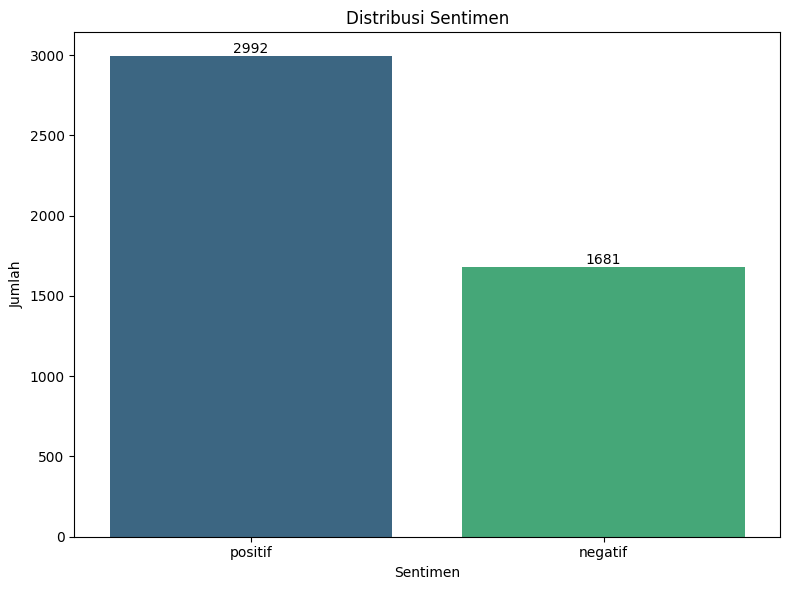

In [19]:
vc = df["sentiment"].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=vc.index, y=vc.values, palette="viridis")
ax.set_title("Distribusi Sentimen")
ax.set_xlabel("Sentimen")
ax.set_ylabel("Jumlah")

# add labbel
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

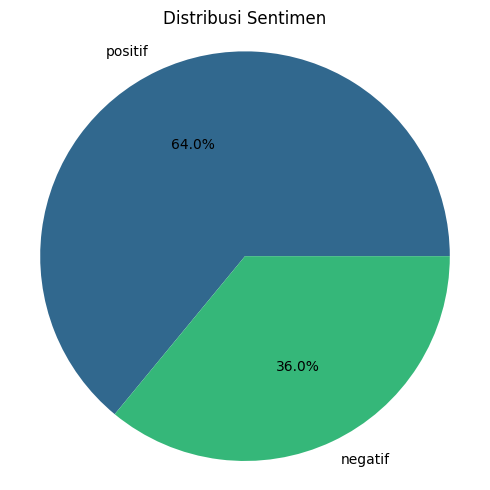

In [20]:
# piechart
plt.figure(figsize=(5, 5))
plt.pie(vc.values, labels=vc.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(vc)))
plt.title("Distribusi Sentimen")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Top 30 kata (overall)

In [21]:
def top_tokens(texts: List[str], topn: int = 30) -> List[Tuple[str,int]]:
    c = Counter()
    for s in texts:
        c.update(s.split())

    for t in ["<user>", "<url>"]:
        if t in c: del c[t]
    return c.most_common(topn)

tops = top_tokens(df["text_clean"].tolist(), topn=30)

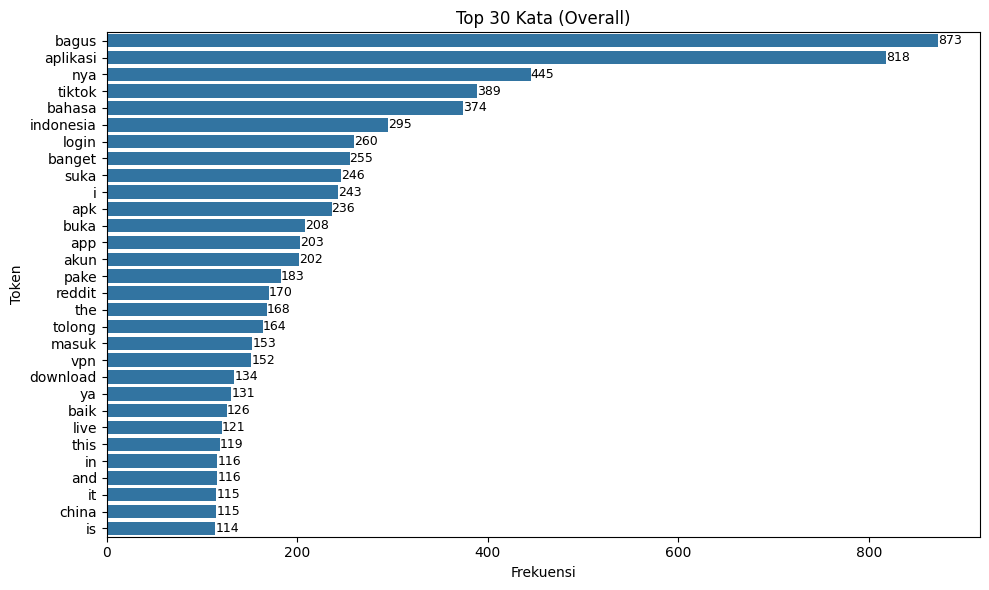

In [22]:
tops_df = pd.DataFrame(tops, columns=["token","freq"])

plt.figure(figsize=(10,6))
ax = sns.barplot(x="freq", y="token", data=tops_df)
plt.title("Top 30 Kata (Overall)")
plt.xlabel("Frekuensi")
plt.ylabel("Token")

# add labbel
for container in ax.containers:
    ax.bar_label(container, size=9, label_type="edge")

plt.tight_layout()
plt.show()

## Top 10 kata per sentimen

/tmp/ipython-input-3706083966.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="freq", y="token", data=tops_sentiment_df, ax=ax, palette="viridis")
/tmp/ipython-input-3706083966.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="freq", y="token", data=tops_sentiment_df, ax=ax, palette="viridis")


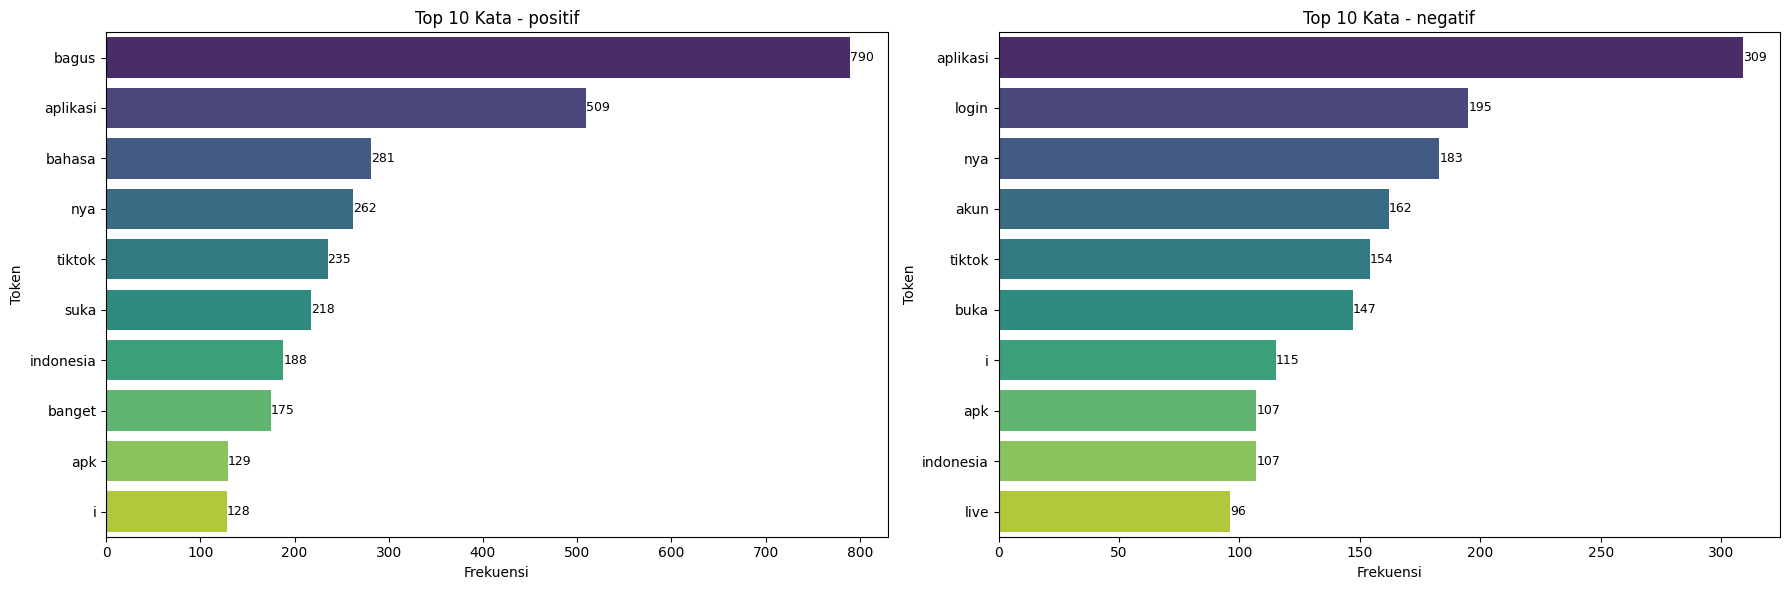

In [23]:
sentiments = df["sentiment"].unique()
fig, axes = plt.subplots(1, len(sentiments), figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    subset = df.loc[df["sentiment"] == sentiment, "text_clean"]
    if subset.empty:
        continue
    tops_sentiment = top_tokens(subset.tolist(), topn=10)
    tops_sentiment_df = pd.DataFrame(tops_sentiment, columns=["token", "freq"])

    ax = axes[i]
    sns.barplot(x="freq", y="token", data=tops_sentiment_df, ax=ax, palette="viridis")
    ax.set_title(f"Top 10 Kata - {sentiment}")
    ax.set_xlabel("Frekuensi")
    ax.set_ylabel("Token")

    for container in ax.containers:
        ax.bar_label(container, size=9, label_type="edge")

plt.tight_layout()
plt.show()

## WordCloud - Seluruh data

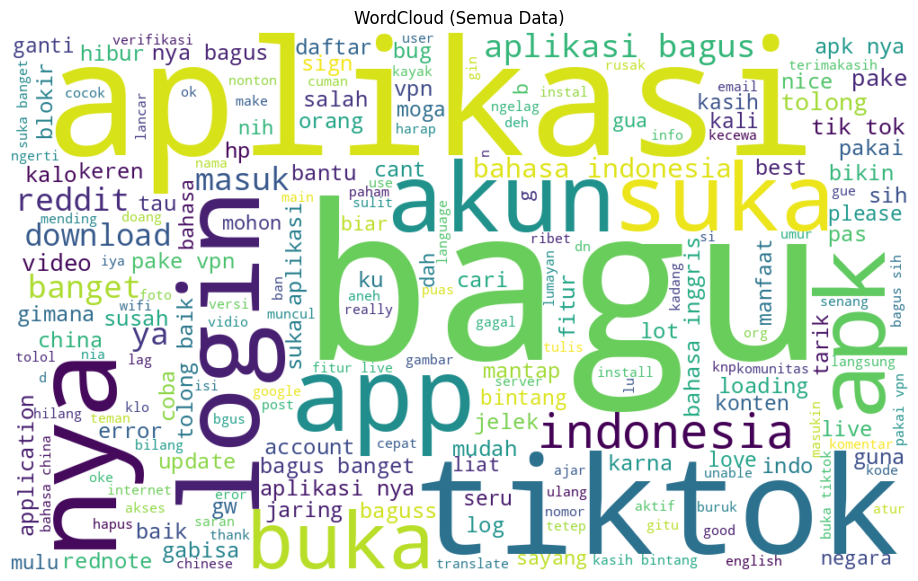

In [24]:
wc_text = " ".join(df["text_clean"].tolist())

wc = WordCloud(width=1000, height=600, background_color="white").generate(wc_text)
plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (Semua Data)")
plt.show()

## WordCloud - Per Sentimen

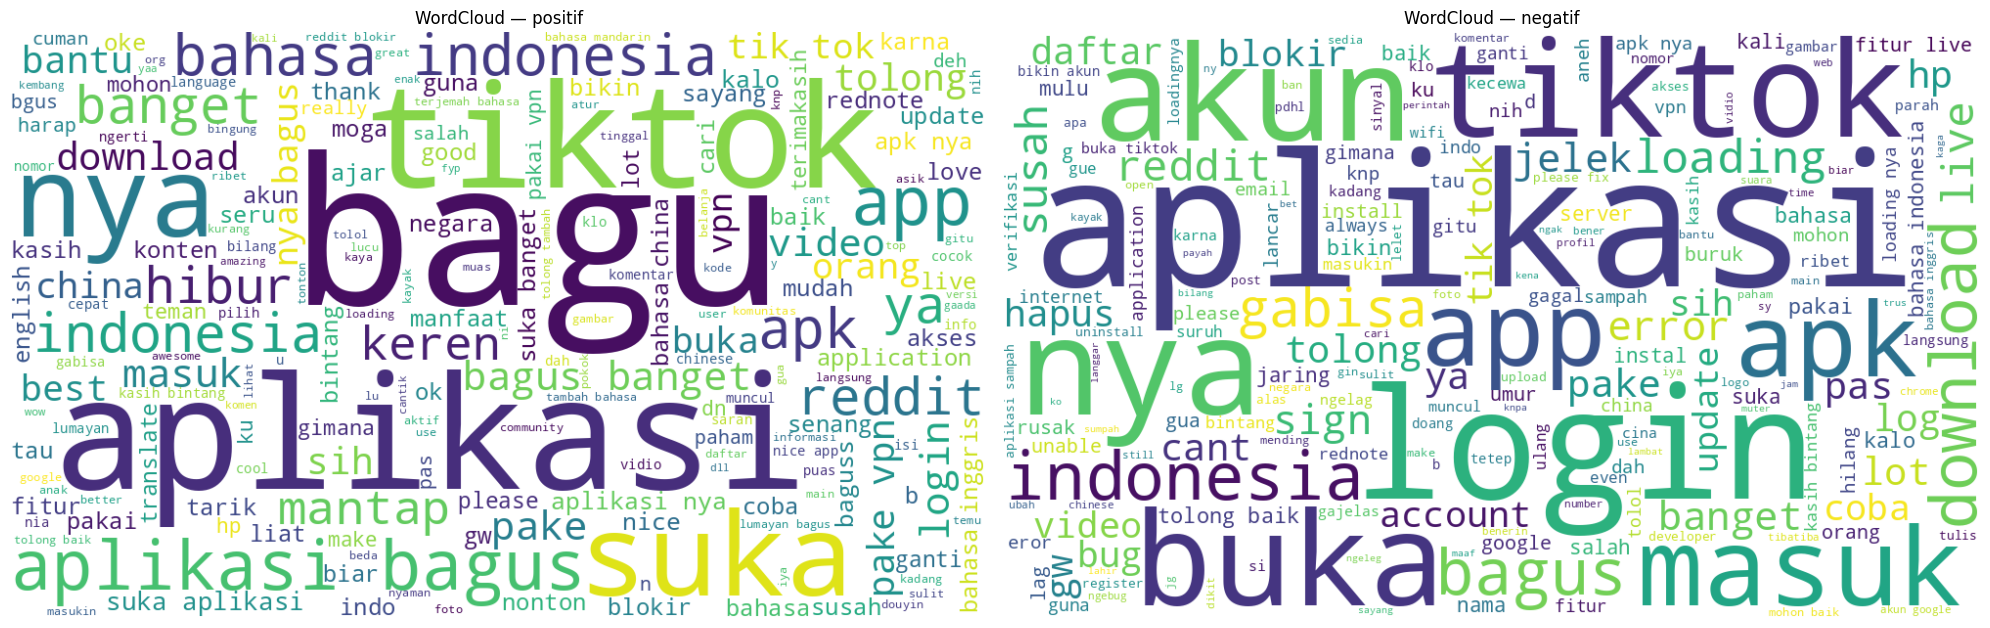

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for i, label in enumerate(["positif", "negatif"]):
    sub = df.loc[df["sentiment"]==label, "text_clean"]
    if sub.empty:
        continue
    text = " ".join(sub.tolist())
    wc = WordCloud(width=1000, height=600, background_color="white").generate(text)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"WordCloud — {label}")

plt.tight_layout()
plt.show()

karena pada wordcloud diatas terlihat bahwa ada beberapa kata yang overlap (bersebrangan) maka akan saya lakukan penghapusan kata tersebut agar hasil terlihat lebih jelas antar sentiment

### Removal Overlap Tokens

In [26]:
# hitung frekuensi per kelas
freq_by_cls = {}
for s in df["sentiment"].unique():
    toks = " ".join(df.loc[df["sentiment"]==s, "text_clean"].astype(str)).split()
    freq_by_cls[s] = Counter(toks)

# cari token yang “bersebrangan”
presence = defaultdict(int)
for s, cnt in freq_by_cls.items():
    for w, c in cnt.items():
        if c >= 3:
            presence[w] += 1

overlap_tokens = {w for w, k in presence.items() if k >= 2}
print("Jumlah token overlap:", len(overlap_tokens))

Jumlah token overlap: 405


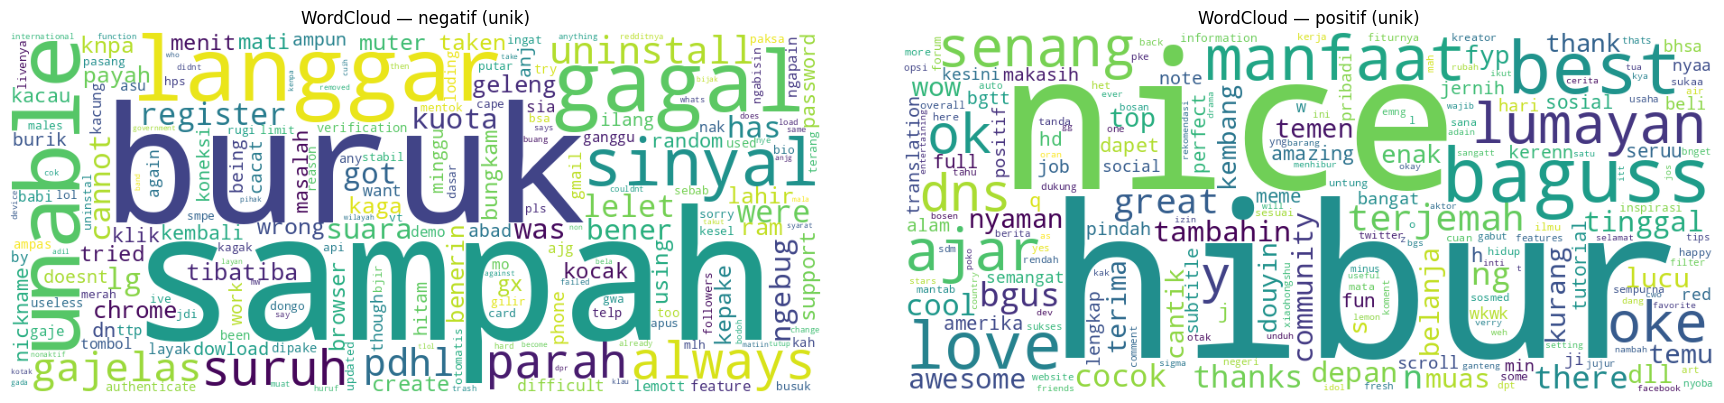

In [27]:
# filter frekuensi
uniq_freq_by_cls = {
    s: Counter({w:c for w,c in cnt.items() if w not in overlap_tokens})
    for s, cnt in freq_by_cls.items()
}

plt.figure(figsize=(18,4))
for i, s in enumerate(sorted(uniq_freq_by_cls.keys())):
    plt.subplot(1, len(uniq_freq_by_cls), i+1)
    wc = WordCloud(width=900, height=400, background_color="white").generate_from_frequencies(uniq_freq_by_cls[s])
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud — {s} (unik)")

plt.tight_layout()
plt.show()

diatas adalah hasil dari `removal overlap tokens`, tampak lebih jelas ketimbang sebelumnya

In [28]:
df_overlap = pd.DataFrame(
    {"token": list(overlap_tokens)}
).sort_values("token").reset_index(drop=True)

# hapus token overlap dari tiap dokumen
def drop_overlap_words(text: str) -> str:
    if not isinstance(text, str):
        return ""
    toks = text.split()
    toks = [t for t in toks if t not in overlap_tokens]
    return " ".join(toks)

df["text_final"] = df["text_clean"].astype(str).apply(drop_overlap_words)
df.head()

,review,rating,sentiment,text_clean,text_final
1,Sangat bagus,5,positif,bagus,
2,Jelek banget aplikasinya gak bisa buat live,5,positif,jelek banget aplikasi live,
3,Keren,5,positif,keren,
4,good,4,positif,bagus,
5,sangat bagus,5,positif,bagus,


In [29]:
# cek baris kosong
df["text_final"] = df["text_final"].fillna("").str.strip()
df["n_tok_fix"] = df["text_final"].str.split().str.len()
print("Baris kosong:", (df["n_tok_fix"]==0).sum())

Baris kosong: 1383


In [30]:
mask = df["n_tok_fix"] == 0
df.loc[mask, "text_final"] = df.loc[mask, "text_clean"].astype(str).str.strip()
df["n_tok_fix"] = df["text_final"].str.split().str.len()

df = df[df["n_tok_fix"] > 0].copy()
df.drop(columns=["n_tok_fix"], inplace=True)

In [31]:
df.head()

,review,rating,sentiment,text_clean,text_final
1,Sangat bagus,5,positif,bagus,bagus
2,Jelek banget aplikasinya gak bisa buat live,5,positif,jelek banget aplikasi live,jelek banget aplikasi live
3,Keren,5,positif,keren,keren
4,good,4,positif,bagus,bagus
5,sangat bagus,5,positif,bagus,bagus


# Data Modelling & Evaluation

In [33]:
# mapping sentiment
df["label"] = df["sentiment"].map({"positif": 1, "negatif": 0})
df.head()

,review,rating,sentiment,text_clean,text_final,label
1,Sangat bagus,5,positif,bagus,bagus,1
2,Jelek banget aplikasinya gak bisa buat live,5,positif,jelek banget aplikasi live,jelek banget aplikasi live,1
3,Keren,5,positif,keren,keren,1
4,good,4,positif,bagus,bagus,1
5,sangat bagus,5,positif,bagus,bagus,1


In [83]:
# splitting data
test_size = 0.2
random_state = 42

X = df["text_clean"]
y = df["label"]

In [84]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)
print(f"Train: {len(y_train)} | Test: {len(y_test)}")

Train: 3570 | Test: 893


In [85]:
# vectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)

(3570, 4231) (893, 4231)


### SMOTE

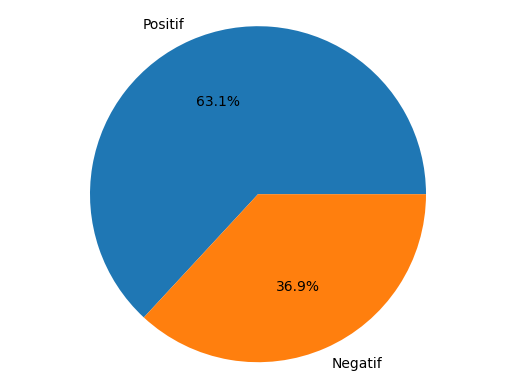

In [86]:
# Class Imbalance Check
plt.pie(y_train.value_counts(),
        labels=["Positif", "Negatif"],
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [87]:
# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_dense = X_train_tfidf.toarray()
X_train_smote, y_train_smote = smote.fit_resample(X_train_dense, y_train)

In [88]:
print("After SMOTE:", X_train_smote.shape, y_train_smote.shape)
X_test_dense = X_test_tfidf.toarray()

After SMOTE: (4506, 4231) (4506,)


/tmp/ipython-input-1469296731.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plt.pie(pd.value_counts(y_train_smote),


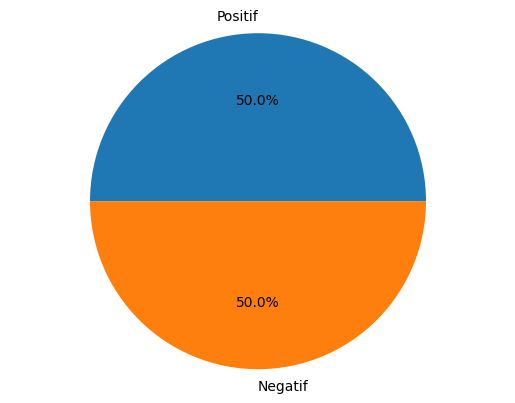

In [89]:
# Class Imbalance Check
plt.pie(pd.value_counts(y_train_smote),
        labels=['Positif', 'Negatif'],
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

### Inisialisasi Model (RF & SVM)

In [95]:
# SVM baseline
svc = SVC(random_state=42)
svc.fit(X_train_smote, y_train_smote)

# RandomForest baseline
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [96]:
# function evaluate model
def evaluate_model(name, model, X_test_dense, y_test):
    t0 = time.time()
    y_pred = model.predict(X_test_dense)
    infer_time = time.time() - t0

    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # baris: True POS, True NEG

    print(f"\n=== {name} ===")
    print(f"Infer time: {infer_time:.2f}s")
    print(f"Accuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    print("\nConfusion Matrix [rows: True POS, True NEG | cols: Pred POS, Pred NEG]:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative','Positive'], zero_division=0))

    return {"Model": name, "Accuracy": acc, "Precision": p, "Recall": r, "F1": f1,
            "Infer(s)": infer_time, "cm": cm, "y_pred": y_pred}

In [97]:
# SVM
res_svc = evaluate_model("SVM (RBF) + TF-IDF + SMOTE", svc, X_test_dense, y_test)


=== SVM (RBF) + TF-IDF + SMOTE ===
Infer time: 20.09s
Accuracy: 0.8275 | Precision: 0.8648 | Recall: 0.8617 | F1: 0.8632

Confusion Matrix [rows: True POS, True NEG | cols: Pred POS, Pred NEG]:
[[486  78]
 [ 76 253]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.77       329
    Positive       0.86      0.86      0.86       564

    accuracy                           0.83       893
   macro avg       0.81      0.82      0.81       893
weighted avg       0.83      0.83      0.83       893



In [98]:
# RandomForest
res_rf  = evaluate_model("RandomForest + TF-IDF + SMOTE", rf, X_test_dense, y_test)


=== RandomForest + TF-IDF + SMOTE ===
Infer time: 0.27s
Accuracy: 0.8287 | Precision: 0.8549 | Recall: 0.8777 | F1: 0.8661

Confusion Matrix [rows: True POS, True NEG | cols: Pred POS, Pred NEG]:
[[495  69]
 [ 84 245]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.74      0.76       329
    Positive       0.85      0.88      0.87       564

    accuracy                           0.83       893
   macro avg       0.82      0.81      0.81       893
weighted avg       0.83      0.83      0.83       893



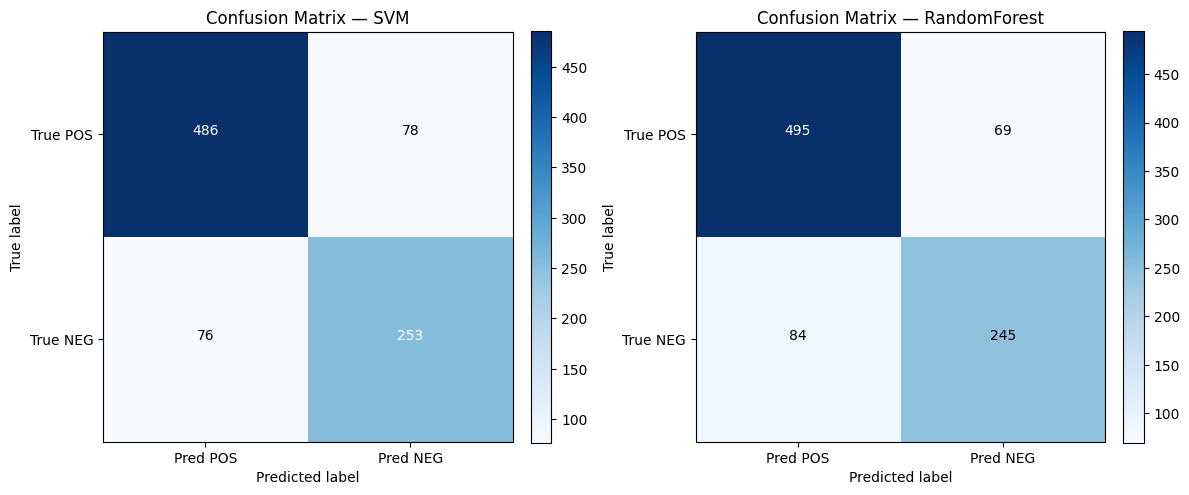

In [99]:
# function plot confusion matrix
def plot_cm(cm, title, ax, cmap='viridis'):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ticks = np.arange(2)
    ax.set_xticks(ticks)
    ax.set_xticklabels(["Pred POS","Pred NEG"])
    ax.set_yticks(ticks)
    ax.set_yticklabels(["True POS","True NEG"])
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_cm(res_svc["cm"], "Confusion Matrix — SVM", axes[0], cmap='Blues')
plot_cm(res_rf["cm"],  "Confusion Matrix — RandomForest", axes[1], cmap='Blues')

plt.tight_layout()
plt.show()

In [100]:
# Tabel perbandingan metrik
comp = pd.DataFrame([{
    "Model": r["Model"],
    "Accuracy (%)": round(r["Accuracy"]*100, 2),
    "Precision (%)": round(r["Precision"]*100, 2),
    "Recall (%)": round(r["Recall"]*100, 2),
    "F1 (%)": round(r["F1"]*100, 2),
    "Infer (s)": round(r["Infer(s)"], 2),
} for r in [res_svc, res_rf]]).sort_values("F1 (%)", ascending=False)
display(comp)

,Model,Accuracy (%),Precision (%),Recall (%),F1 (%),Infer (s)
1,RandomForest + TF-IDF + SMOTE,82.87,85.49,87.77,86.61,0.27
0,SVM (RBF) + TF-IDF + SMOTE,82.75,86.48,86.17,86.32,20.09


In [101]:
# Tabel distribusi sentimen (model terbaik)
best = res_svc if res_svc["F1"] >= res_rf["F1"] else res_rf
sent_map = {1: "Positive", 0: "Negative"}
sent_table = pd.Series(best["y_pred"]).map(sent_map).value_counts().rename_axis("Sentiment").reset_index(name="Count")
print(f"Best model: {best['Model']}")
display(sent_table)

Best model: RandomForest + TF-IDF + SMOTE


,Sentiment,Count
0,Positive,579
1,Negative,314


In [105]:
# save model
vec_path  = "/content/tfidf_vectorizer.joblib"
svm_path  = "/content/svm_rbf_model.joblib"
rf_path   = "/content/random_forest_model.joblib"
meta_path = "/content/metadata.json"
zip_path  = "/content/artifacts.zip"

# simpan objek
joblib.dump(tfidf_vectorizer, vec_path)
joblib.dump(svc, svm_path)
joblib.dump(rf, rf_path)

# metadata ringkas
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "vectorizer": "sklearn.feature_extraction.text.TfidfVectorizer",
    "models": ["svm_rbf_model.joblib", "random_forest_model.joblib"],
    "labels": {"negative": 0, "positive": 1}
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# zip file
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in [vec_path, svm_path, rf_path, meta_path]:
        z.write(p, arcname=os.path.basename(p))

files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>